# Exercise 1 
**Yifat Hadad & Hadar Sharvit**

# 0. imports and utils

In [1]:
import pandas as pd
import numpy as np
import torch.cuda
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import torch.utils.data as data_utils
from google.colab import drive
import matplotlib.pyplot as plt

In [34]:
def basic_plot(x_data, y_data, title, x_title, y_title):
    """
    basic function that plots data
    """
    plt.plot(x_data, y_data)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.grid()

#1. gloabal variables

In [ ]:
drive.mount('/content/gdrive')
device = "cuda" if torch.cuda.is_available() else "cpu"
try:
    neg = pd.read_csv(
        "/content/gdrive/MyDrive/Master/Year 1/Intro to DL/Exercises/Intro-to-Deep-Learning/ex1/Data/neg_A0201.txt",
        names=['seq'])
    pos = pd.read_csv(
        "/content/gdrive/MyDrive/Master/Year 1/Intro to DL/Exercises/Intro-to-Deep-Learning/ex1/Data/pos_A0201.txt",
        names=['seq'])
except FileNotFoundError:
    neg_path = "/content/gdrive/MyDrive/IDL/Ex1/Data/neg_A0201.txt"
    pos_path = "/content/gdrive/MyDrive/IDL/Ex1/Data/pos_A0201.txt"
    neg = pd.read_csv(neg_path, names=['seq'])
    pos = pd.read_csv(pos_path, names=['seq'])

amino_letters = 'ACDEFGHIKLMNPQRSTVWY'  # Amino acids signs
one_hot_values = [str(i) + acid for i in range(9) for acid in amino_letters]  # one hot features

#2. Pre-processing data

The pre-processing is mostly dedicated to the generation of a one-hot representation for every peptide. this was done in the following manner:
given some peptide (`ABCDEFGHI` for example), the features 

`0A,1B,2C,3D,4E,5F,6G,7H` and `8I`are generated, where for every label `iX`, `i` represents the index of the amino acid `X`. 

another thing to point out is that the training data consist of much more negative samples than positive ones. this was addressed using a weighted loss function (below)



In [5]:
def generate_X(peptid_df):
    """
    generates a sample matrix with all the relevant dummy variables from the given peptid dataframe
    :param peptid_df: a dataframe with the peptids
    :return: altered df
    """
    peptid_df[one_hot_values] = 0  # adding all one hot encoding labels
    for i, peptid_name in enumerate(peptid_df['seq']):
        peptid_one_hot = [str(i) + acid for i, acid in enumerate(peptid_name)]  # columns that should be assigned 1
        peptid_df.at[i, peptid_one_hot] = 1
    return peptid_df.drop(["seq"], axis=1)

In [6]:
def preprocess():
    """
    :return: training and test X,y
    """
    X_pos, X_neg = generate_X(pos), generate_X(neg)
    y_pos, y_neg = np.ones(X_pos.shape[0]), np.zeros(X_neg.shape[0])
    X, y = pd.concat([X_pos, X_neg]), np.concatenate([y_pos, y_neg])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    X_train_tensor = torch.tensor(X_train.values).float()
    X_test_tensor = torch.tensor(X_test.values).float()
    y_train_tensor = torch.tensor(y_train).float()
    y_test_tensor = torch.tensor(y_test).float()

    train = data_utils.TensorDataset(X_train_tensor, y_train_tensor)
    test = data_utils.TensorDataset(X_test_tensor, y_test_tensor)
    return train, test, y_test

#3. Model initialization

Various architectural design changes were made, before settling for the following. it appeared that `ReLU`
non-linearities work the best, and two hidden layers were sufficient to achieve small loss. furthermore,
the first hidden layer expands the dimension of the problem - this was discussed in class and is considered
a good approach overall.

In [7]:
class MLP(nn.Module):
    """
      Multilayer Perceptron.
    """

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(180, 512),
            nn.ReLU(),
            nn.Linear(512, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
        )

    def forward(self, x):
        """
        forward pass
        :param x: network input
        :return: network output
        """
        return self.layers(x)

In [8]:
def accuracy(y_pred, y_true):
    """
    calculates the accuracy given a prediction and true labels
    """
    rounded_y_pred = torch.round(torch.sigmoid(y_pred))
    agree = (y_true == rounded_y_pred).sum()
    return 100 * agree.float() / y_true.shape[0]

#4. Train & Test methods

In [31]:
def train(dataloader, model, loss_fn, optimizer, epochs):
    """
    trains the network using SGD
    """
    loss_arr = []  # for future plots
    size = len(dataloader.dataset)
    model.train()
    for t in range(epochs):
      epoch_loss = 0
      for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        y = y[..., np.newaxis]
        prediction = model(X)
        loss = loss_fn(prediction, y)
        acc = accuracy(prediction, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

      loss_arr.append(epoch_loss / size)
      print(f"Epoch: {t}; Train Loss: {epoch_loss / size :.5f};")
    return loss_arr

In [37]:
def test(dataloader, model, loss_fn, epochs):
    """
    tests the trained model and provides train loss as well as a prediction
    for the test data
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    all_predictions = []
    loss_arr = []
    model.eval()  # tell pyTorch we do not use backprop
    for t in range(epochs):
      epoch_loss = 0
      with torch.no_grad():
        for X, y in dataloader:
          X, y = X.to(device), y.to(device)
          y = y[..., np.newaxis]
          prediction = model(X)
          prediction = torch.round(torch.sigmoid(prediction))
          all_predictions.append(prediction.cpu().numpy())
          loss = loss_fn(prediction, y)
          epoch_loss += loss.item()

      loss_arr.append(epoch_loss / size)
      print(f"Epoch: {t}; Test Loss: {epoch_loss / size :.5f};")

    y_pred = [label for pred in all_predictions for label in pred]
    return y_pred, loss_arr


#5. Initializing network parameters

pre-processing

In [11]:
train_data, test_data, y_test = preprocess()

initialization: the parameters were chosen based on trial and error - for example, when the convergence was slow, we've increased the `learnine_rate`. another example would be that `batch_size` was optimized to the fact that if it was large - it might cause high bias and if it is small it would cause high variance.

furthermore, we have used a binary cross entropy loss function with weights that amplify the effect of possitive instances (as those were scarce)

In [19]:
epochs, batch_size, learning_rate = 30, 64, 7e-3
model = MLP().to(device)
pos_weight_ratio = torch.ones(1) * (neg.shape[0] / pos.shape[0])
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_ratio)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_data, batch_size)
test_dataloader = DataLoader(test_data, batch_size)

# 6. Results
train and loss error

In [32]:
train_loss_arr = train(train_dataloader, model, loss_fn, optimizer, epochs)

Epoch: 0; Train Loss: 0.01801;
Epoch: 1; Train Loss: 0.01557;
Epoch: 2; Train Loss: 0.01286;
Epoch: 3; Train Loss: 0.01096;
Epoch: 4; Train Loss: 0.00969;
Epoch: 5; Train Loss: 0.00888;
Epoch: 6; Train Loss: 0.00836;
Epoch: 7; Train Loss: 0.00801;
Epoch: 8; Train Loss: 0.00775;
Epoch: 9; Train Loss: 0.00755;
Epoch: 10; Train Loss: 0.00737;
Epoch: 11; Train Loss: 0.00722;
Epoch: 12; Train Loss: 0.00708;
Epoch: 13; Train Loss: 0.00696;
Epoch: 14; Train Loss: 0.00683;
Epoch: 15; Train Loss: 0.00671;
Epoch: 16; Train Loss: 0.00659;
Epoch: 17; Train Loss: 0.00647;
Epoch: 18; Train Loss: 0.00635;
Epoch: 19; Train Loss: 0.00622;
Epoch: 20; Train Loss: 0.00609;
Epoch: 21; Train Loss: 0.00596;
Epoch: 22; Train Loss: 0.00582;
Epoch: 23; Train Loss: 0.00567;
Epoch: 24; Train Loss: 0.00552;
Epoch: 25; Train Loss: 0.00536;
Epoch: 26; Train Loss: 0.00519;
Epoch: 27; Train Loss: 0.00502;
Epoch: 28; Train Loss: 0.00485;
Epoch: 29; Train Loss: 0.00468;


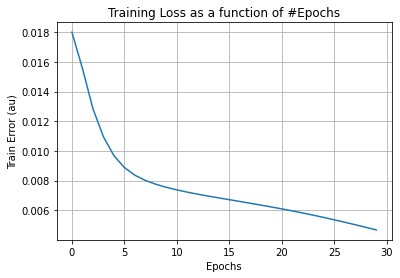

In [35]:
basic_plot(range(epochs), train_loss_arr, "Training Loss as a function of #Epochs", "Epochs", "Train Error (au)")

In [38]:
y_pred, test_loss_arr = test(test_dataloader, model, loss_fn, epochs)

Epoch: 0; Test Loss: 0.01549;
Epoch: 1; Test Loss: 0.01549;
Epoch: 2; Test Loss: 0.01549;
Epoch: 3; Test Loss: 0.01549;
Epoch: 4; Test Loss: 0.01549;
Epoch: 5; Test Loss: 0.01549;
Epoch: 6; Test Loss: 0.01549;
Epoch: 7; Test Loss: 0.01549;
Epoch: 8; Test Loss: 0.01549;
Epoch: 9; Test Loss: 0.01549;
Epoch: 10; Test Loss: 0.01549;
Epoch: 11; Test Loss: 0.01549;
Epoch: 12; Test Loss: 0.01549;
Epoch: 13; Test Loss: 0.01549;
Epoch: 14; Test Loss: 0.01549;
Epoch: 15; Test Loss: 0.01549;
Epoch: 16; Test Loss: 0.01549;
Epoch: 17; Test Loss: 0.01549;
Epoch: 18; Test Loss: 0.01549;
Epoch: 19; Test Loss: 0.01549;
Epoch: 20; Test Loss: 0.01549;
Epoch: 21; Test Loss: 0.01549;
Epoch: 22; Test Loss: 0.01549;
Epoch: 23; Test Loss: 0.01549;
Epoch: 24; Test Loss: 0.01549;
Epoch: 25; Test Loss: 0.01549;
Epoch: 26; Test Loss: 0.01549;
Epoch: 27; Test Loss: 0.01549;
Epoch: 28; Test Loss: 0.01549;
Epoch: 29; Test Loss: 0.01549;


In [39]:
len(y_pred)  # TODO: this doesnt have the right shape

82470

In [ ]:
basic_plot(range(epochs), test_loss_arr, "Test Loss as a function of #Epochs", "Epochs",
           "Test Error (au)")  #TODO: problem with test error

confusion matrix and measurements

In [ ]:
def measurements_plots(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Neg", "Pos"])
    display_cm.plot()
    print(classification_report(y_test, all_predictions))


measurements_plots(y_test, y_pred)